# Volume scan from  multiple sweeps using xradar
This example shows how to create a volume scan from multiple sweep files stored on AWS. The volume scan structure is based on [tree-like](https://xarray-datatree.readthedocs.io/en/latest/generated/datatree.DataTree.html) hierarchical collection of xarray objects 

## Imports

In [1]:
import fsspec
import xradar as xd
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings
from pandas import to_datetime
from datetime import datetime
from functools import reduce
from matplotlib import pyplot
from datatree import DataTree, open_datatree
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
warnings.simplefilter("ignore")
# pyplot.style.use('dark_background')

## Access radar data from the Colombian radar network on AWS
Access data from the IDEAM bucket on AWS. Detailed information can be found [here](https://openradar-docs--102.org.readthedocs.build/projects/xradar/en/102/notebooks/Read-plot-Sigmet-data-from-AWS.html) 

In [2]:
def create_query(date, radar_site):
    """
    Creates a string for quering the IDEAM radar files stored in AWS bucket
    :param date: date to be queried. e.g datetime(2021, 10, 3, 12). Datetime python object
    :param radar_site: radar site e.g. Guaviare
    :return: string with a IDEAM radar bucket format
    """
    if (date.hour != 0) and (date.hour != 0):
        return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d%H}'
    elif (date.hour != 0) and (date.hour == 0):
        return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}'
    else:
        return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}'

Using `create_query` function we can list all files within the AWS bucket for a selected time-date.

In [3]:
date_query = datetime(2023, 4, 7, 3)
radar_name = "Barrancabermeja" 
query = create_query(date=date_query, radar_site=radar_name)
str_bucket = 's3://s3-radaresideam/'
fs = fsspec.filesystem("s3", anon=True)
radar_files = sorted(fs.glob(f"{str_bucket}{query}*"))

## Let's check the elevation at each file using `xradar.datatree` module

IDEAM radar network operates with a volume scan every five minutes. Each volume scan has four different tasks 
* *SURVP* "super-resolution" sweep at the lowest elevation angle, usually 0.5 deg,  with 720 degrees in azimuth (every 0.5 deg)
* *PRECA* task with 1.5, 2.4, 3.0, and 5.0 elevation angles and shorter range than *SURVP*
* *PRECB* task with 6.4 and 8.0 elevation angles and a shorter range than the previous task
* *PRECC* task with 10.0, 12.5, and 15.0 with a shorter range than all the previous tasks.

In [4]:
# List of first four task files
task_files = [fsspec.open_local(f'simplecache::s3://{i}', s3={'anon': True}, filecache={'cache_storage': '.'}) 
             for i in radar_files[:4]]
# list of xradar datatrees
ls_dt = [xd.io.open_iris_datatree(i).xradar.georeference() for i in task_files]

# sweeps and elevations within each task
for i in ls_dt:
    sweeps = list(i.children.keys())
    print(f"task sweeps: {sweeps}")
    for j in sweeps:
        print(f"{j}: {i[j].sweep_fixed_angle.values: .1f} [deg], {i[j].range.values[-1] / 1e3:.1f} [km]")
    print("----------------------------------------------------------------")

task sweeps: ['sweep_0']
sweep_0:  1.3 [deg], 298.9 [km]
----------------------------------------------------------------
task sweeps: ['sweep_0', 'sweep_1', 'sweep_2', 'sweep_3']
sweep_0:  1.5 [deg], 224.8 [km]
sweep_1:  2.4 [deg], 224.8 [km]
sweep_2:  3.1 [deg], 224.8 [km]
sweep_3:  5.1 [deg], 224.8 [km]
----------------------------------------------------------------
task sweeps: ['sweep_0', 'sweep_1']
sweep_0:  6.4 [deg], 175.0 [km]
sweep_1:  8.0 [deg], 175.0 [km]
----------------------------------------------------------------
task sweeps: ['sweep_0', 'sweep_1', 'sweep_2']
sweep_0:  10.0 [deg], 99.0 [km]
sweep_1:  12.5 [deg], 99.0 [km]
sweep_2:  15.0 [deg], 99.0 [km]
----------------------------------------------------------------


## Tree-like hierarchical object
Now we can create a tree-like hierarchical were each children corresponds to each taks within the same volume coverage pattern (VCP)

In [51]:
def create_query(date, radar_site):
    """
    Creates a string for quering the IDEAM radar files stored in AWS bucket
    :param date: date to be queried. e.g datetime(2021, 10, 3, 12). Datetime python object
    :param radar_site: radar site e.g. Guaviare
    :return: string with a IDEAM radar bucket format
    """
    if (date.hour != 0) and (date.hour != 0):
        return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d%H}'
    elif (date.hour != 0) and (date.hour == 0):
        return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}'
    else:
        return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}'


def data_accessor(file):
    """
    Open AWS S3 file(s), which can be resolved locally by file caching
    """
    return fsspec.open_local(f'simplecache::s3://{file}', s3={'anon': True}, filecache={'cache_storage': '/tmp/radar/'})


def create_vcp(ls_dt):
    """
    Creates a tree-like object for each volume scan
    """
    dtree = [{f"{i[j].sweep_fixed_angle.values: .1f}".replace(' ', ''):
                  fix_angle(i[j].copy()).ds.xradar.georeference() for j in i.children} for i in ls_dt]
    dtree = reduce(lambda a, b: dict(a, **b), dtree)
    return DataTree.from_dict(dtree)


def create_path(dt):
    el = np.array([float(i) for i in list(dt.children)]).min()
    dt = pd.to_datetime(dt[f'{el}'].time.values[0])
    return f"{dt:%Y%m%d%H%M}", dt


def rename_children(dt):
    for i in list(dt.children):
        dt[i].name = f"{dt[i].sweep_fixed_angle.values: .1f}".replace(' ', '')
    return dt


def mult_vcp(radar_files):
    """
    Creates a tree-like object for multiple volumes scan every 4th file in the bucket
    """
    paths = []
    ls_time = []
    dt_dict = {}
    for idx, i in enumerate(radar_files):
        if idx % 4 == 0:
            ls_files = radar_files[idx: idx + 4]
            # ls_sigmet = [xd.io.open_iris_datatree(data_accessor(j)).xradar.georeference() for j in ls_files]
            ls_sigmet = [xd.io.open_iris_datatree(data_accessor(j)) for j in ls_files]

            ls_sigmet = [rename_children(i) for i in ls_sigmet]
            vcp = create_vcp(ls_sigmet)
            path, time = create_path(vcp)
            paths.append(path)
            ls_time.append(time)
            dt_dict[f"{path}"] = vcp

    root_ds = xr.Dataset(
        {
            "vcp_time": xr.DataArray(
                paths,
                dims=["time"],
                coords={"time": pd.Series(list(ls_time)).sort_values()},
            ),
        },
        coords={
            "time": pd.Series(list(ls_time)).sort_values(),
        },
    )
    root_ds = root_ds.sortby("time")
    dt_dict["/"] = root_ds
    return DataTree.from_dict(dt_dict)

def fix_angle(ds):
    angle_dict = xd.util.extract_angle_parameters(ds)
    # display(angle_dict)
    start_ang = angle_dict["start_angle"]
    stop_ang = angle_dict["stop_angle"]
    angle_res = angle_dict["angle_res"]
    direction = angle_dict["direction"]

    # first find exact duplicates and remove
    ds = xd.util.remove_duplicate_rays(ds)

    # second reindex according to retrieved parameters
    ds = xd.util.reindex_angle(
        ds, start_ang, stop_ang, angle_res, direction, method="nearest"
    )
    return ds

In [58]:
# let's test it using the first 24 files in the bucket. We can include more files for visualization. e.g. radar_files[:96]
vcps_dt = mult_vcp(radar_files[:24])

This is the tree-like object structure with timestamps at each vcp and its corresponding tasks and sweeps.

In [59]:
display(list(vcps_dt.groups))

['/',
 '/202304070300',
 '/202304070300/1.3',
 '/202304070300/1.5',
 '/202304070300/2.4',
 '/202304070300/3.1',
 '/202304070300/5.1',
 '/202304070300/6.4',
 '/202304070300/8.0',
 '/202304070300/10.0',
 '/202304070300/12.5',
 '/202304070300/15.0',
 '/202304070305',
 '/202304070305/1.3',
 '/202304070305/1.5',
 '/202304070305/2.4',
 '/202304070305/3.1',
 '/202304070305/5.1',
 '/202304070305/6.4',
 '/202304070305/8.0',
 '/202304070305/10.0',
 '/202304070305/12.5',
 '/202304070305/15.0',
 '/202304070310',
 '/202304070310/1.3',
 '/202304070310/1.5',
 '/202304070310/2.4',
 '/202304070310/3.1',
 '/202304070310/5.1',
 '/202304070310/6.4',
 '/202304070310/8.0',
 '/202304070310/10.0',
 '/202304070310/12.5',
 '/202304070310/15.0',
 '/202304070316',
 '/202304070316/1.3',
 '/202304070316/1.5',
 '/202304070316/2.4',
 '/202304070316/3.1',
 '/202304070316/5.1',
 '/202304070316/6.4',
 '/202304070316/8.0',
 '/202304070316/10.0',
 '/202304070316/12.5',
 '/202304070316/15.0',
 '/202304070320',
 '/202304070

In [60]:
vcps_dt

DataTree('None', parent=None)
│   Dimensions:   (time: 6)
│   Coordinates:
│     * time      (time) datetime64[ns] 2023-04-07T03:00:28.846000 ... 2023-04-07...
│   Data variables:
│       vcp_time  (time) <U12 '202304070300' '202304070305' ... '202304070325'
├── DataTree('202304070300')
│   ├── DataTree('1.3')
│   │       Dimensions:            (azimuth: 720, range: 994)
│   │       Coordinates:
│   │         * azimuth            (azimuth) float64 0.25 0.75 1.25 ... 358.8 359.2 359.8
│   │         * range              (range) float32 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
│   │           elevation          (azimuth) float64 1.318 1.318 1.318 ... 1.318 1.318 1.318
│   │           time               (azimuth) datetime64[ns] 2023-04-07T03:00:28.846000 .....
│   │           longitude          float64 -73.76
│   │           latitude           float64 6.933
│   │           altitude           float64 105.0
│   │           spatial_ref        int64 0
│   │           x                  (azimuth, range) float64 4.362 5.671 ... -1.302e+03
│   │           y                  (azimuth, range) float64 999.7 1.3e+03 ... 2.985e+05
│   │           z                  (azimuth, range) float64 128.1 135.0 ... 1.223e+04
│   │       Data variables: (12/17)
│   │           DBTH               (azimuth, range) float64 8.5 25.0 2.5 ... -32.0 -32.0
│   │           DBZH               (azimuth, range) float64 -32.0 -32.0 ... -32.0 -32.0
│   │           VRADH              (azimuth, range) float64 -5.403 -5.613 2.413 ... 0.0 0.0
│   │           WRADH              (azimuth, range) float64 0.5986 0.02603 ... 0.0 0.0
│   │           ZDR                (azimuth, range) float64 1.625 1.875 2.25 ... -8.0 -8.0
│   │           KDP                (azimuth, range) float64 0.04458 0.04458 ... -0.0 -0.0
│   │           ...                 ...
│   │           DB_DBZE8           (azimuth, range) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
│   │           sweep_mode         <U20 'azimuth_surveillance'
│   │           sweep_number       int64 ...
│   │           prt_mode           <U7 ...
│   │           follow_mode        <U7 ...
│   │           sweep_fixed_angle  float64 1.3
│   ├── DataTree('1.5')
│   │       Dimensions:            (azimuth: 360, range: 747)
│   │       Coordinates:
│   │         * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│   │         * range              (range) float32 1e+03 1.3e+03 ... 2.245e+05 2.248e+05
│   │           elevation          (azimuth) float64 1.472 1.472 1.472 ... 1.472 1.472 1.472
│   │           time               (azimuth) datetime64[ns] 2023-04-07T03:01:14.569000 .....
│   │           longitude          float64 -73.76
│   │           latitude           float64 6.933
│   │           altitude           float64 105.0
│   │           spatial_ref        int64 0
│   │           x                  (azimuth, range) float64 8.724 11.34 ... -1.959e+03
│   │           y                  (azimuth, range) float64 999.6 1.3e+03 ... 2.245e+05
│   │           z                  (azimuth, range) float64 130.8 138.5 ... 8.847e+03
│   │       Data variables: (12/17)
│   │           DBTH               (azimuth, range) float64 6.5 26.0 3.5 ... -32.0 -32.0
│   │           DBZH               (azimuth, range) float64 -32.0 -32.0 ... -32.0 -32.0
│   │           VRADH              (azimuth, range) float64 -0.8373 0.4186 6.419 ... 0.0 0.0
│   │           WRADH              (azimuth, range) float64 1.592 2.077 1.211 ... 0.0 0.0
│   │           ZDR                (azimuth, range) float64 2.938 7.5 3.75 ... -8.0 -8.0
│   │           KDP                (azimuth, range) float64 0.04458 0.04458 ... -0.0 -0.0
│   │           ...                 ...
│   │           DB_DBZE8           (azimuth, range) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
│   │           sweep_mode         <U20 'azimuth_surveillance'
│   │           sweep_number       int64 ...
│   │           prt_mode           <U7 ...
│   │           follow_mode        <U7 ...
│   │   

Now we have 6 vcps in one tree-like hierarchical object.

In [61]:
times = list(vcps_dt.children)
display(times)

['202304070300',
 '202304070305',
 '202304070310',
 '202304070316',
 '202304070320',
 '202304070325']

In [62]:
print(f"Size of data in tree = {vcps_dt.nbytes / 1e9 :.2f} GB")

Size of data in tree = 2.10 GB


### PPI animation using the lowest elevation angle

We can create an animation using the `FuncAnimation` module from `matplotlib` package

In [63]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
proj_crs = xd.georeference.get_crs(vcps_dt[times[0]]['1.3'])
cart_crs = ccrs.Projection(proj_crs)
sc = vcps_dt[times[0]]['1.3'].DBZH.plot.pcolormesh(x="x", y="y", vmin=-10, 
                                                      vmax=50, cmap="Spectral_r", 
                                                      edgecolors="face", 
                                                      transform=cart_crs,
                                                      ax=ax)

title = f"Barranca radar - {vcps_dt[times[0]]['1.3'].sweep_fixed_angle.values: .1f} [deg] \n {pd.to_datetime(vcps_dt[times[0]]['1.3'].time.values[0]):%Y-%m-%d %H:%M}UTC"
ax.set_title(title)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                  linewidth=1, color="gray", alpha=0.3, linestyle="--")
plt.gca().xaxis.set_major_locator(plt.NullLocator())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()

def update_plot(t):
    sc.set_array(vcps_dt[t]['1.3'].DBZH.values.ravel())
    ax.set_title(f"Barranca radar - {vcps_dt[t]['1.3'].sweep_fixed_angle.values: .1f} [deg] \n {pd.to_datetime(vcps_dt[t]['1.3'].time.values[0]):%Y-%m-%d %H:%M}UTC")

ani = FuncAnimation(fig, update_plot, frames=times,
                    interval=150)
plt.close()
display(HTML(ani.to_html5_video()))

## Bonus: Analysis-ready data, cloud-optimized (ARCO) format 

Tree-like hierarchical data can be stored using ARCO format.

In [67]:
zarr_store = './multiple_vcp_test.zarr'
_ = vcps_dt.to_zarr(zarr_store, mode='w')

In [68]:
! ls multiple_vcp_test.zarr

202304070300  202304070310  202304070320  time
202304070305  202304070316  202304070325  vcp_time


Read ARCO format data using `open_datatree`

In [69]:
dt = open_datatree(zarr_store, engine="zarr")

Now we can slicing data by time, task and sweep:

In [70]:
display(dt)

DataTree('None', parent=None)
│   Dimensions:   (time: 6)
│   Coordinates:
│     * time      (time) datetime64[ns] 2023-04-07T03:00:28.846000 ... 2023-04-07...
│   Data variables:
│       vcp_time  (time) <U12 ...
├── DataTree('202304070300')
│   ├── DataTree('1.3')
│   │       Dimensions:            (azimuth: 720, range: 994)
│   │       Coordinates:
│   │           altitude           float64 ...
│   │         * azimuth            (azimuth) float64 0.25 0.75 1.25 ... 358.8 359.2 359.8
│   │           latitude           float64 ...
│   │           longitude          float64 ...
│   │         * range              (range) float32 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
│   │           spatial_ref        int64 ...
│   │           x                  (azimuth, range) float64 ...
│   │           y                  (azimuth, range) float64 ...
│   │           z                  (azimuth, range) float64 ...
│   │       Data variables: (12/19)
│   │           DBTH               (azimuth, range) float32 ...
│   │           DBZH               (azimuth, range) float32 ...
│   │           DB_DBTE8           (azimuth, range) int16 ...
│   │           DB_DBZE8           (azimuth, range) int16 ...
│   │           DB_HCLASS          (azimuth, range) int16 ...
│   │           KDP                (azimuth, range) float32 ...
│   │           ...                 ...
│   │           follow_mode        <U7 ...
│   │           prt_mode           <U7 ...
│   │           sweep_fixed_angle  float64 ...
│   │           sweep_mode         <U20 ...
│   │           sweep_number       int64 ...
│   │           time               (azimuth) datetime64[ns] ...
│   ├── DataTree('1.5')
│   │       Dimensions:            (azimuth: 360, range: 747)
│   │       Coordinates:
│   │           altitude           float64 ...
│   │         * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│   │           latitude           float64 ...
│   │           longitude          float64 ...
│   │         * range              (range) float32 1e+03 1.3e+03 ... 2.245e+05 2.248e+05
│   │           spatial_ref        int64 ...
│   │           x                  (azimuth, range) float64 ...
│   │           y                  (azimuth, range) float64 ...
│   │           z                  (azimuth, range) float64 ...
│   │       Data variables: (12/19)
│   │           DBTH               (azimuth, range) float32 ...
│   │           DBZH               (azimuth, range) float32 ...
│   │           DB_DBTE8           (azimuth, range) int16 ...
│   │           DB_DBZE8           (azimuth, range) int16 ...
│   │           DB_HCLASS          (azimuth, range) int16 ...
│   │           KDP                (azimuth, range) float32 ...
│   │           ...                 ...
│   │           follow_mode        <U7 ...
│   │           prt_mode           <U7 ...
│   │           sweep_fixed_angle  float64 ...
│   │           sweep_mode         <U20 ...
│   │           sweep_number       int64 ...
│   │           time               (azimuth) datetime64[ns] ...
│   ├── DataTree('10.0')
│   │       Dimensions:            (azimuth: 360, range: 654)
│   │       Coordinates:
│   │           altitude           float64 ...
│   │         * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│   │           latitude           float64 ...
│   │           longitude          float64 ...
│   │         * range              (range) float32 1e+03 1.15e+03 ... 9.88e+04 9.895e+04
│   │           spatial_ref        int64 ...
│   │           x                  (azimuth, range) float64 ...
│   │           y                  (azimuth, range) float64 ...
│   │           z                  (azimuth, range) float64 ...
│   │       Data variables: (12/19)
│   │           DBTH               (azimuth, range) float32 ...
│   │           DBZH               (azimuth, range) float32 ...
│   │           DB_DBTE8           (azimuth, range) int16 ...
│   │           DB_DBZE8           (azimuth,

In [71]:
def get_data(dt, elevation=1.3):
    ls_ds = []
    for i in dt['vcp_time'].values:
        data = dt[i][f"{elevation}"].ds
        ls_ds.append(data)
    return xr.concat(ls_ds, dim=f"times")

In [72]:
ds_le = get_data(dt)

In [73]:
ds_le

<xarray.Dataset>
Dimensions:            (times: 6, azimuth: 720, range: 994)
Coordinates:
    altitude           float64 105.0
  * azimuth            (azimuth) float64 0.25 0.75 1.25 ... 358.8 359.2 359.8
    latitude           float64 6.933
    longitude          float64 -73.76
  * range              (range) float32 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
    spatial_ref        int64 0
    x                  (times, azimuth, range) float64 4.362 ... -1.302e+03
    y                  (times, azimuth, range) float64 999.7 ... 2.985e+05
    z                  (times, azimuth, range) float64 128.1 135.0 ... 1.223e+04
Dimensions without coordinates: times
Data variables: (12/19)
    DBTH               (times, azimuth, range) float32 8.5 25.0 ... -32.0 -32.0
    DBZH               (times, azimuth, range) float32 -32.0 -32.0 ... -32.0
    DB_DBTE8           (times, azimuth, range) int16 28753 15933 16979 ... 0 0 0
    DB_DBZE8           (times, azimuth, range) int16 0 0 0 0 0 0 ... 0 0 0 0 0 0
    DB_HCLASS          (times, azimuth, range) int16 4369 4369 4369 ... 0 0 0
    KDP                (times, azimuth, range) float32 0.04458 0.04458 ... -0.0
    ...                 ...
    follow_mode        (times) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
    prt_mode           (times) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
    sweep_fixed_angle  (times) float64 1.3 1.3 1.3 1.3 1.3 1.3
    sweep_mode         (times) <U20 'azimuth_surveillance' ... 'azimuth_surve...
    sweep_number       (times) int64 0 0 0 0 0 0
    time               (times, azimuth) datetime64[ns] 2023-04-07T03:00:28.84...

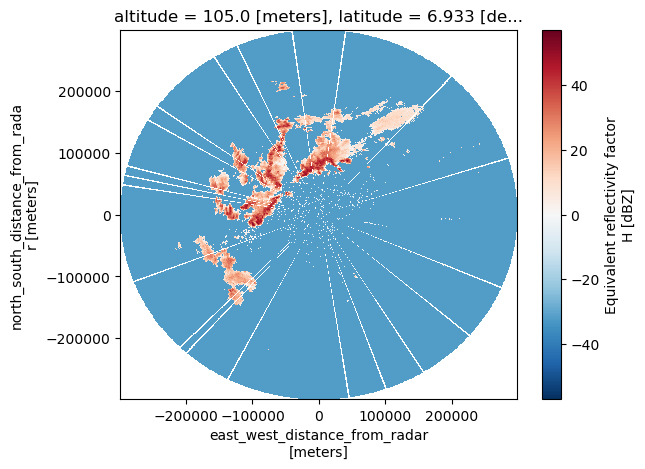

In [75]:
ds_le.isel(times=0).DBZH.plot(x="x", y='y')